## Assignment 2: Set up the work for data-driven inference based on CitiBike data. 

In [28]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os

%pylab inline

if os.getenv ('PUI2016') is None:
    print ("Must set env variable PUI2016")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUI2016")

Populating the interactive namespace from numpy and matplotlib


## IDEA:
### Older people are less likely to use citibikes than young people.
## NULL HYPOTHESIS
### The ratio of people over 45 years old biking on weekends over people biking on weekdays is the same or higher than the ratio of people under 45 years old biking over weekends to people below biking on weekdays
## _$H_0$_ : $\frac{B_{\mathrm{weekend}}}{B_{\mathrm{week}}} <= \frac{O_{\mathrm{weekend}}}{O_{\mathrm{week}}}$
## _$H_1$_ : $\frac{B_{\mathrm{weekend}}}{B_{\mathrm{week}}} > \frac{O_{\mathrm{weekend}}}{O_{\mathrm{week}}}$

or identically:

## _$H_0$_ : $\frac{B_{\mathrm{weekend}}}{B_{\mathrm{week}}} - \frac{O_{\mathrm{weekend}}}{O_{\mathrm{week}}} <= 0 $
## _$H_1$_ : $\frac{B_{\mathrm{weekend}}}{B_{\mathrm{week}}} - \frac{O_{\mathrm{weekend}}}{O_{\mathrm{week}}} > 0$
### Significance Level p = 0.05, which means I want the probability of getting a result at least significant as mine to be less than 5%.

### I am starting with citibike data from Jan 2015

In [33]:

### this peice of code is from "https://github.com/fedhere/PUI2016_fb55/blob/master/HW3_fb55/citibikes_gender.ipynb"

### A function to download the data: simple bash commands can be run by preceding them with !
### but more complex command lines with variable arguments need to be build as strng and run with os.system
### this code cell does a lot of things: looks for existing files, download a file if none is there, unzips it, moves it.
### you do not have to have a code cell this complicated. 
### As long as 
### 1) your research is reproducible: we can access the same file as you without having to ask you for the file
### 2) and your data is stored in a directory pointed to by the env variable PUIDATA 
### you will be fine. We already explored how to download data in other notebooks!

def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [34]:
datestring = '201501'
getCitiBikeCSV(datestring)

file in place, you can continue


In [35]:
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
# df is the dataframe where the content of the csv file is stored
df['date'] = pd.to_datetime(df['starttime'])
# note that with dataframes I can refer to variables as dictionary keys, 
# i.e. df['starttime'] or as attributes: df.starttime. 
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2,2015-01-01 00:01:00
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1,2015-01-01 00:02:00
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1,2015-01-01 00:04:00
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1,2015-01-01 00:04:00
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1,2015-01-01 00:05:00


In [7]:
df.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender', u'date'],
      dtype='object')

In [36]:
df.drop([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'gender'], axis = 1, inplace = True)

In [37]:
df.head(5)

,birth year,date
0,1960.0,2015-01-01 00:01:00
1,1963.0,2015-01-01 00:02:00
2,1974.0,2015-01-01 00:04:00
3,1969.0,2015-01-01 00:04:00
4,1977.0,2015-01-01 00:05:00


In [38]:
df.columns = ['birth_year','date']

In [39]:
df.head()

,birth_year,date
0,1960.0,2015-01-01 00:01:00
1,1963.0,2015-01-01 00:02:00
2,1974.0,2015-01-01 00:04:00
3,1969.0,2015-01-01 00:04:00
4,1977.0,2015-01-01 00:05:00


#### Seperate people below 45 (_b) years old from people over 45( _o) to test the hypotheses.
#### In this csv file birth_year  > = 1970, age <=45
#### Plot the number of trips per week day

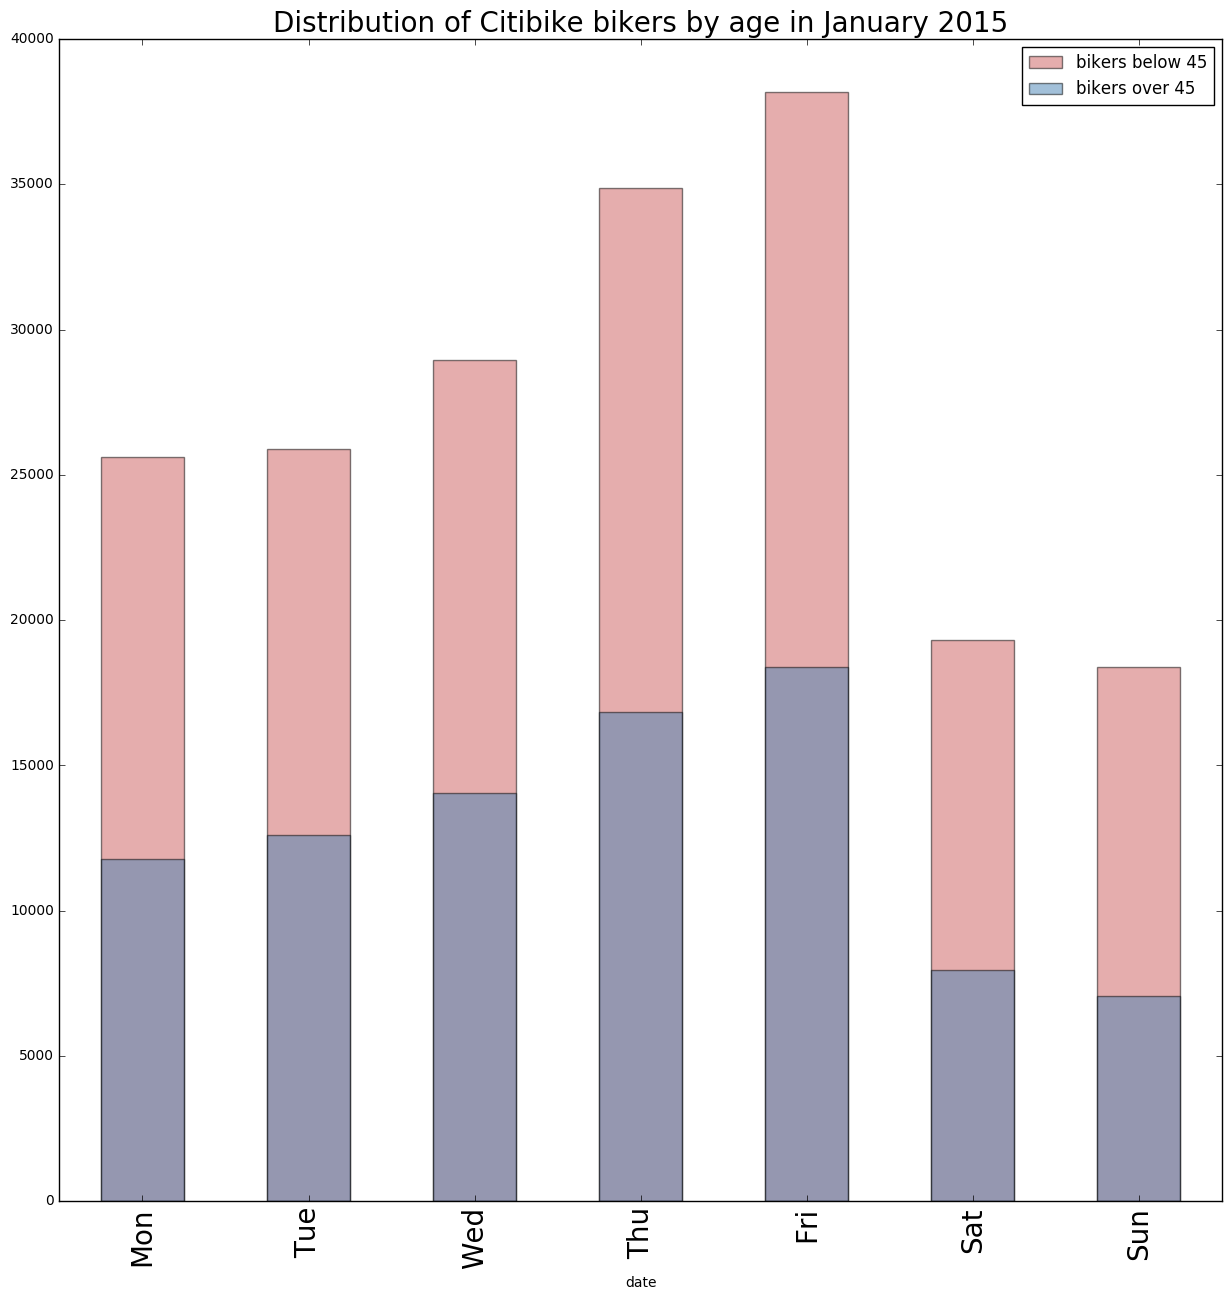

In [46]:
fig = pl.figure(figsize(15,15))

#instad of plotting with matplotlib i.e. plot() i use the plot method in pandas
norm_b = 1
((df['date'][df['birth_year'] >= 1970].groupby([df['date'].dt.weekday]).count()) / norm_b).plot(kind="bar", color='IndianRed', alpha=0.5, label='bikers below 45')

norm_o = 1
ax = ((df['date'][df['birth_year'] < 1970].groupby([df['date'].dt.weekday]).count()) / norm_o).plot(kind="bar", color='SteelBlue', alpha=0.5, label='bikers over 45')

tmp = ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=20)
pl.title('Distribution of Citibike bikers by age in January 2015', fontsize = 20)
pl.legend()

### Figure 1a: Distribution of Citibike bikers by age in January 2015, absolute counts.

#### The counts have errors. For N counts the error is qurt(N) - this is because counts follow a Poisson statistic

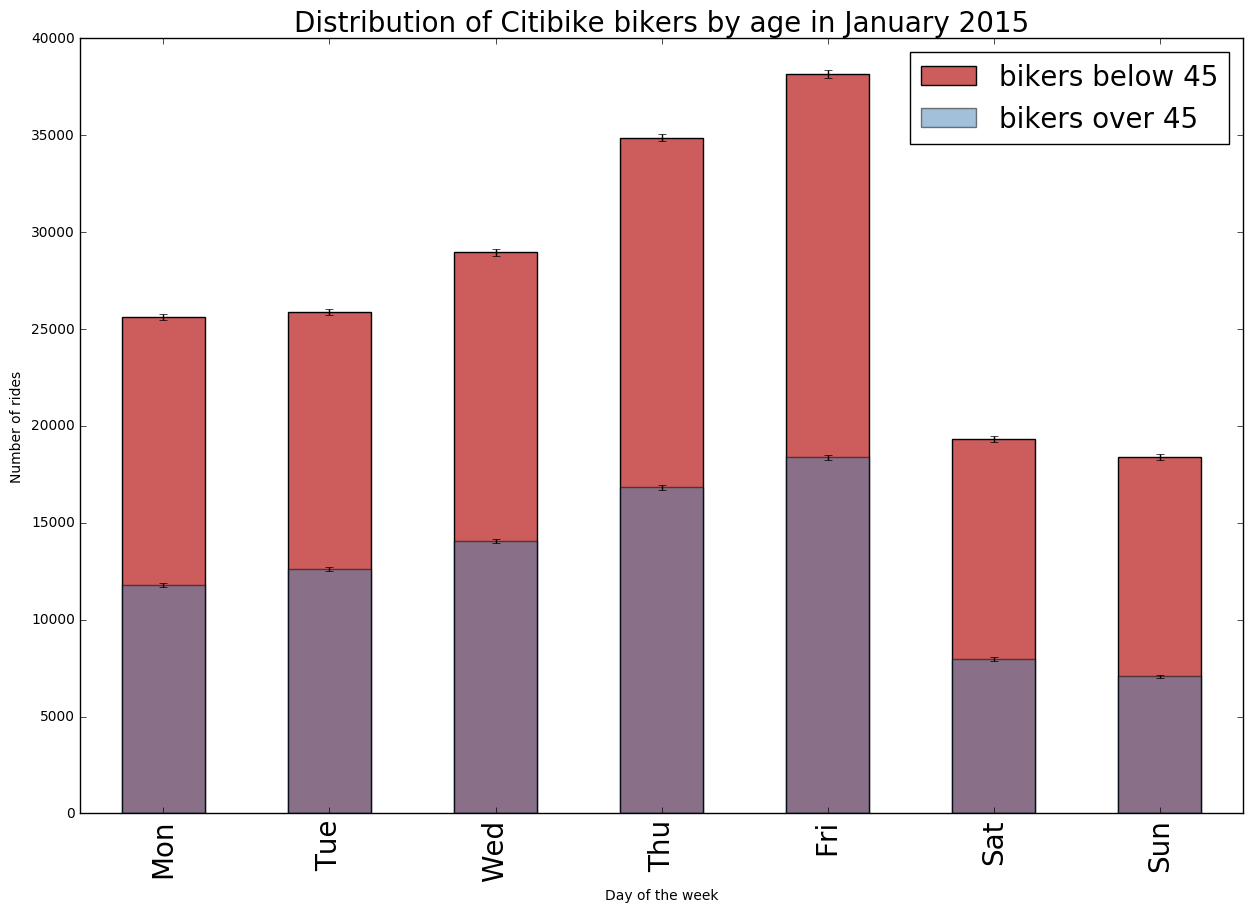

In [50]:
fig=pl.figure(figsize(15,10))

counts_b = df.date[df.birth_year >= 1970].groupby([df.date.dt.weekday]).count()
norm_b = 1
error_b = np.sqrt(counts_b)
ax=((counts_b) / norm_b).plot(kind="bar",color='IndianRed',  yerr=[
            ((error_b) / norm_b, (error_b) / norm_b)], label='women bikers')


counts_o = df.date[df.birth_year < 1970].groupby([df.date.dt.weekday]).count()
norm_o = 1
error_o=np.sqrt(counts_o)
((counts_o) / norm_o).plot(kind="bar", alpha=0.5, yerr=[((error_o) / norm_o, (error_o) / norm_o)], 
                           color='SteelBlue', label='men bikers')
ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=20)
ax.set_ylabel ("Number of rides")
ax.set_xlabel ("Day of the week")
pl.title('Distribution of Citibike bikers by age in January 2015', fontsize = 20)
pl.legend(['bikers below 45','bikers over 45'],fontsize=20)

### Figure 1b: Distribution of Citibike bikers by gender in January 2015, absolute counts, with statistical errors

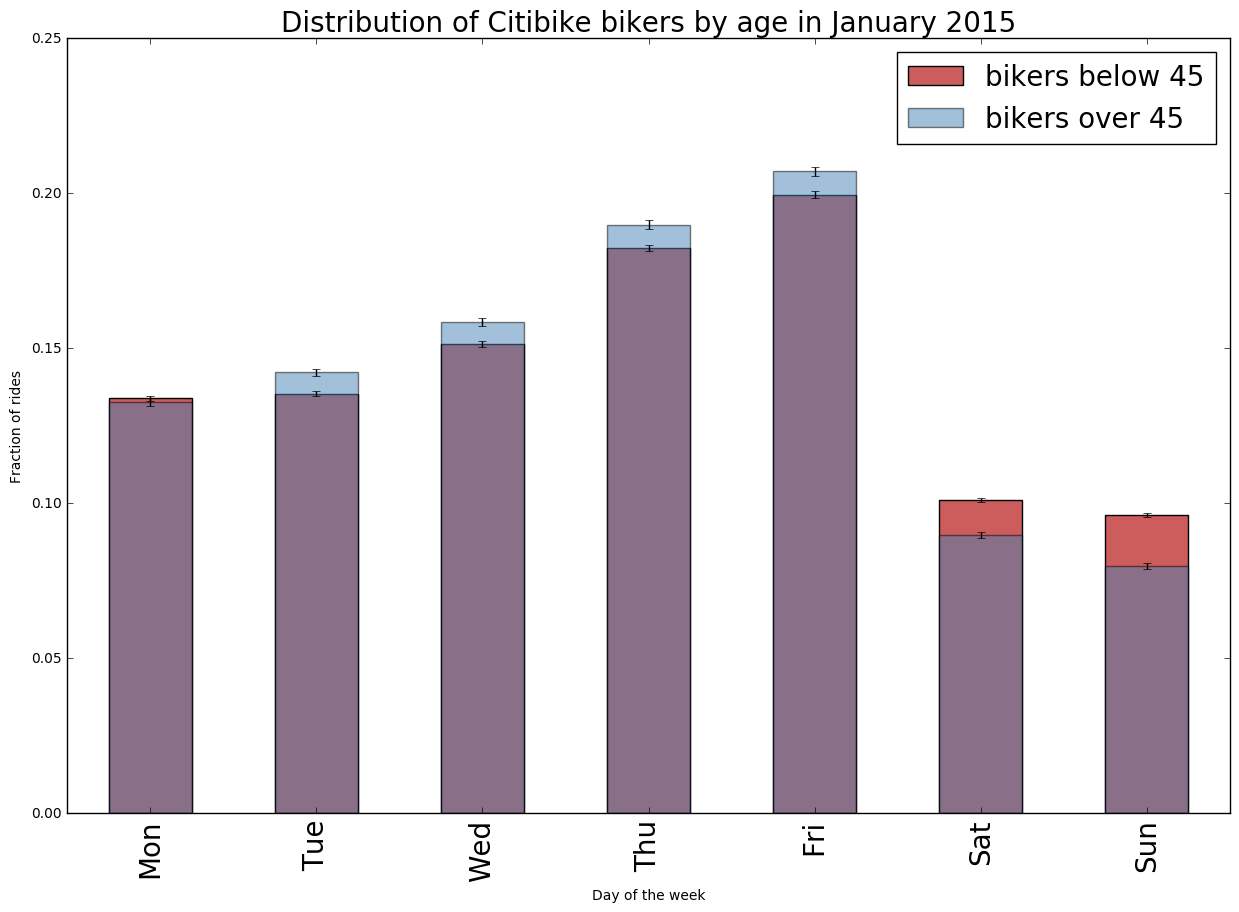

In [52]:
fig = pl.figure(figsize(15,10))

norm_b = counts_b.sum()
error_b = np.sqrt(counts_b)
((counts_b) / norm_b).plot(kind="bar", color='IndianRed',  
                           yerr=[((error_b) / norm_b, (error_b) / norm_b)], 
                           label='women bikers')

norm_o = counts_o.sum()
ax = ((counts_o) / norm_o).plot(kind="bar", alpha=0.5, 
                                yerr=[((error_o) / norm_o, (error_o) / norm_o)], 
                                color='SteelBlue', label='men bikers')

ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=20)
ax.set_ylabel ("Fraction of rides")
ax.set_xlabel ("Day of the week")

pl.title('Distribution of Citibike bikers by age in January 2015', fontsize = 20)
pl.legend(['bikers below 45','bikers over 45'],fontsize=20)

### Figure 2: Distribution of Citibike bikers by gender in January 2015, normalized